# Data Preprocessing

In [2]:
import pandas as pd

# Load data
df = pd.read_csv("/Users/willjettinghoff/Desktop/Wise Jugement/Prelim Data/WJC_firstwave_merged_with_original.csv")

# Define prompts
prompts = [
    "1. What was this difficult decision about? Please describe in detail who was involved, where and when it took place, and what was happening at that time.",
    "2. What specific issues did you encounter when making this difficult decision?",
    "3. What were you thinking when you first encountered this difficult decision?",
    "4. What were you feeling when you first encountered this difficult decision?",
    "5. If you are comfortable sharing, what steps did you take to address this difficult decision?",
    "6. In what ways did this difficult decision affect your life?",
    "7. Is there anything else you would like to share about this difficult decision?"
]

# Merge original-language responses
def merge_open_responses_original(df):
    """
    Merge original-language open-ended responses from either the 'LB' or 'SMB' source format into a unified set of columns.

    For each of the 7 open-ended questions, this function selects the response from 'LB_Open_Q{i}_original' 
    if any are non-missing, otherwise it selects from 'SMB_Open_Q{i}_original'. The resulting values are stored 
    in 'Open_{i}_original'. Additionally, a new column 'open_type_original' is created to indicate the source 
    ('LB' or 'SMB').

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing original-language open-ended responses.

    Returns
    -------
    pandas.DataFrame
        DataFrame with merged original-language responses and source label, with the original LB/SMB columns removed.
    """
    lb = [f'LB_Open_Q{i}_original' for i in range(1, 8)]
    smb = [f'SMB_Open_Q{i}_original' for i in range(1, 8)]
    target = [f'Open_{i}_original' for i in range(1, 8)]

    has_lb = df[lb].notna().any(axis=1)
    df.loc[has_lb, target] = df.loc[has_lb, lb].values
    df.loc[~has_lb, target] = df.loc[~has_lb, smb].values

    df['open_type_original'] = has_lb.map({True: 'LB', False: 'SMB'})
    return df.drop(columns=lb + smb)

# Merge English-translated responses
def merge_open_responses_en(df):
    """
    Merge English-translated open-ended responses from either the 'LB' or 'SMB' source format into a unified set of columns.

    For each of the 7 open-ended questions, this function selects the response from 'LB_Open_Q{i}' 
    if any are non-missing, otherwise it selects from 'SMB_Open_Q{i}'. The results are stored in 
    'Open_{i}_en'. A new column 'open_type_en' indicates the response source ('LB' or 'SMB').

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing English-translated open-ended responses.

    Returns
    -------
    pandas.DataFrame
        DataFrame with merged English responses and source label, with the original LB/SMB columns removed.
    """
    lb = [f'LB_Open_Q{i}' for i in range(1, 8)]
    smb = [f'SMB_Open_Q{i}' for i in range(1, 8)]
    target = [f'Open_{i}_en' for i in range(1, 8)]

    has_lb = df[lb].notna().any(axis=1)
    df.loc[has_lb, target] = df.loc[has_lb, lb].values
    df.loc[~has_lb, target] = df.loc[~has_lb, smb].values

    df['open_type_en'] = has_lb.map({True: 'LB', False: 'SMB'})
    return df.drop(columns=lb + smb)

# Concatenate prompt + response strings
def concatenate_open_responses(df, prefix):
    """
    Concatenate prompt–response pairs into unified narrative fields for open-ended survey responses.

    Constructs two string fields:
    1. 'all_open_{prefix}' — a full concatenation of all 7 prompts with their corresponding responses.
    2. 'Open_Q1_2_{prefix}' — a partial concatenation using only the first two prompts and responses.

    Prompts are fixed; responses are drawn from 'Open_{i}_{prefix}' for i in 1–7. Missing responses 
    are replaced with 'No response.'. Excess whitespace is removed.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with open-ended response columns already merged and labeled.
    prefix : str
        Column suffix indicating response language/context (e.g., 'original' or 'en').

    Returns
    -------
    pandas.DataFrame
        DataFrame with two new columns containing concatenated prompt–response strings.
    """
    response_cols = [f'Open_{i}_{prefix}' for i in range(1, 8)]

    # Full concatenated text
    df[f'all_open_{prefix}'] = (
        prompts[0] + " " + df[response_cols[0]].fillna('<NA>') + " " +
        prompts[1] + " " + df[response_cols[1]].fillna('<NA>') + " " +
        prompts[2] + " " + df[response_cols[2]].fillna('<NA>') + " " +
        prompts[3] + " " + df[response_cols[3]].fillna('<NA>') + " " +
        prompts[4] + " " + df[response_cols[4]].fillna('<NA>') + " " +
        prompts[5] + " " + df[response_cols[5]].fillna('<NA>') + " " +
        prompts[6] + " " + df[response_cols[6]].fillna('<NA>')
    ).str.replace(r'\s+', ' ', regex=True).str.strip()

    # Q1 + Q2
    df[f'Open_Q1_2_{prefix}'] = (
        prompts[0] + " " + df[response_cols[0]].fillna('<NA>') + " " +
        prompts[1] + " " + df[response_cols[1]].fillna('<NA>')
    ).str.replace(r'\s+', ' ', regex=True).str.strip()

    return df

# Execute full pipeline
df = (
    df
    .pipe(merge_open_responses_original)
    .pipe(merge_open_responses_en)
    .loc[lambda d: d[[f'Open_{i}_original' for i in range(1, 8)]].notna().any(axis=1)]
    .reset_index(drop=True)
)

df = concatenate_open_responses(df, prefix='original')
df = concatenate_open_responses(df, prefix='en')

import re

def clean_text(text):
    """
    Remove unwanted artifacts from text using regex.

    Artifacts removed:
    - '&#xa' and '&#xa;'
    - 'xml:space="preserve"' and 'xml:space="preserve">'
    - '_x000D_'
    """
    if pd.isnull(text):
        return text
    return re.sub(r'(&#xa;?|xml:space="preserve">?|_x000D_)', '', text)

columns_to_clean = [ # this is all the text variables, group by type (original language or english translation)
    'Norm_Q_original', 'Open_1_original', 'Open_2_original', 'Open_3_original',
    'Open_4_original', 'Open_5_original', 'Open_6_original', 'Open_7_original',
    'Norm_Q', 'Open_1_en', 'Open_2_en', 'Open_3_en', 'Open_4_en',
    'Open_5_en', 'Open_6_en', 'Open_7_en', 'all_open_original',
    'Open_Q1_2_original', 'all_open_en', 'Open_Q1_2_en'
]

df[columns_to_clean] = df[columns_to_clean].applymap(clean_text)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 85 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Language               1806 non-null   object 
 1   StartDate              1806 non-null   object 
 2   EndDate                1806 non-null   object 
 3   IPAddress              1806 non-null   object 
 4   Progress               1806 non-null   int64  
 5   Duration..in.seconds.  1806 non-null   int64  
 6   Finished               1806 non-null   bool   
 7   RecordedDate           1806 non-null   object 
 8   ResponseId             1806 non-null   object 
 9   RecipientLastName      158 non-null    object 
 10  RecipientFirstName     158 non-null    object 
 11  RecipientEmail         158 non-null    object 
 12  ExternalReference      158 non-null    object 
 13  LocationLatitude       1806 non-null   object 
 14  LocationLongitude      1806 non-null   object 
 15  Dist

/var/folders/_l/01s2ywxs5tj9v5v4r4cg9z4w0000gn/T/ipykernel_90997/1910429426.py:158: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_clean] = df[columns_to_clean].applymap(clean_text)


# Embed text

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import os

# LOCAL output directory: where to save embeddings on your machine. Example:
output_dir = '/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/' # 

def compute_and_save_embeddings(df, column_name, output_path, model, batch_size=32):
    """Reusable function for vectorizing a text variable and saving the embeddings.

    Args:
        df (_type_): Pandas dataframe
        column_name (_type_): your text variable
        output_path (_type_): local on your computer or shared drive
        model (_type_): the text embedding model
        batch_size (int, optional): The number of documents to be embed at once. Device dependant. Defaults to 32.
    """
    texts = df[column_name].fillna('').astype(str).tolist()
    embeddings = model.encode(
        texts, # a text variable
        batch_size=batch_size, # number of documents to vectorize per batch
        show_progress_bar=True
        )
    np.save(output_path, embeddings)

# List of target columns and models to test
# in this case an original and english translated version of FRee Responses to Questions 1 & 2 Concatenated
target_columns = ['Open_Q1_2_original', 'Open_Q1_2_en']
model_names = [ # Variety of models available in SentenceTransformers()
    'sentence-transformers/all-mpnet-base-v2', # english
    'sentence-transformers/stsb-xlm-r-multilingual',
    'sentence-transformers/LaBSE',
    'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
    'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
    'sentence-transformers/use-cmlm-multilingual',
    'sentence-transformers/distiluse-base-multilingual-cased-v2',
    
]

# For each model and column pair, embed the documents with the model on your computer
for model_name in model_names:
    model = SentenceTransformer(model_name)
    for col in target_columns:
        model_id = model_name.split("/")[-1]
        output_path = os.path.join(output_dir, f'emb_{col}_{model_id}.npy')
        compute_and_save_embeddings(df, col, output_path, model=model, batch_size=32)

KeyboardInterrupt: 

# UMAP Plots

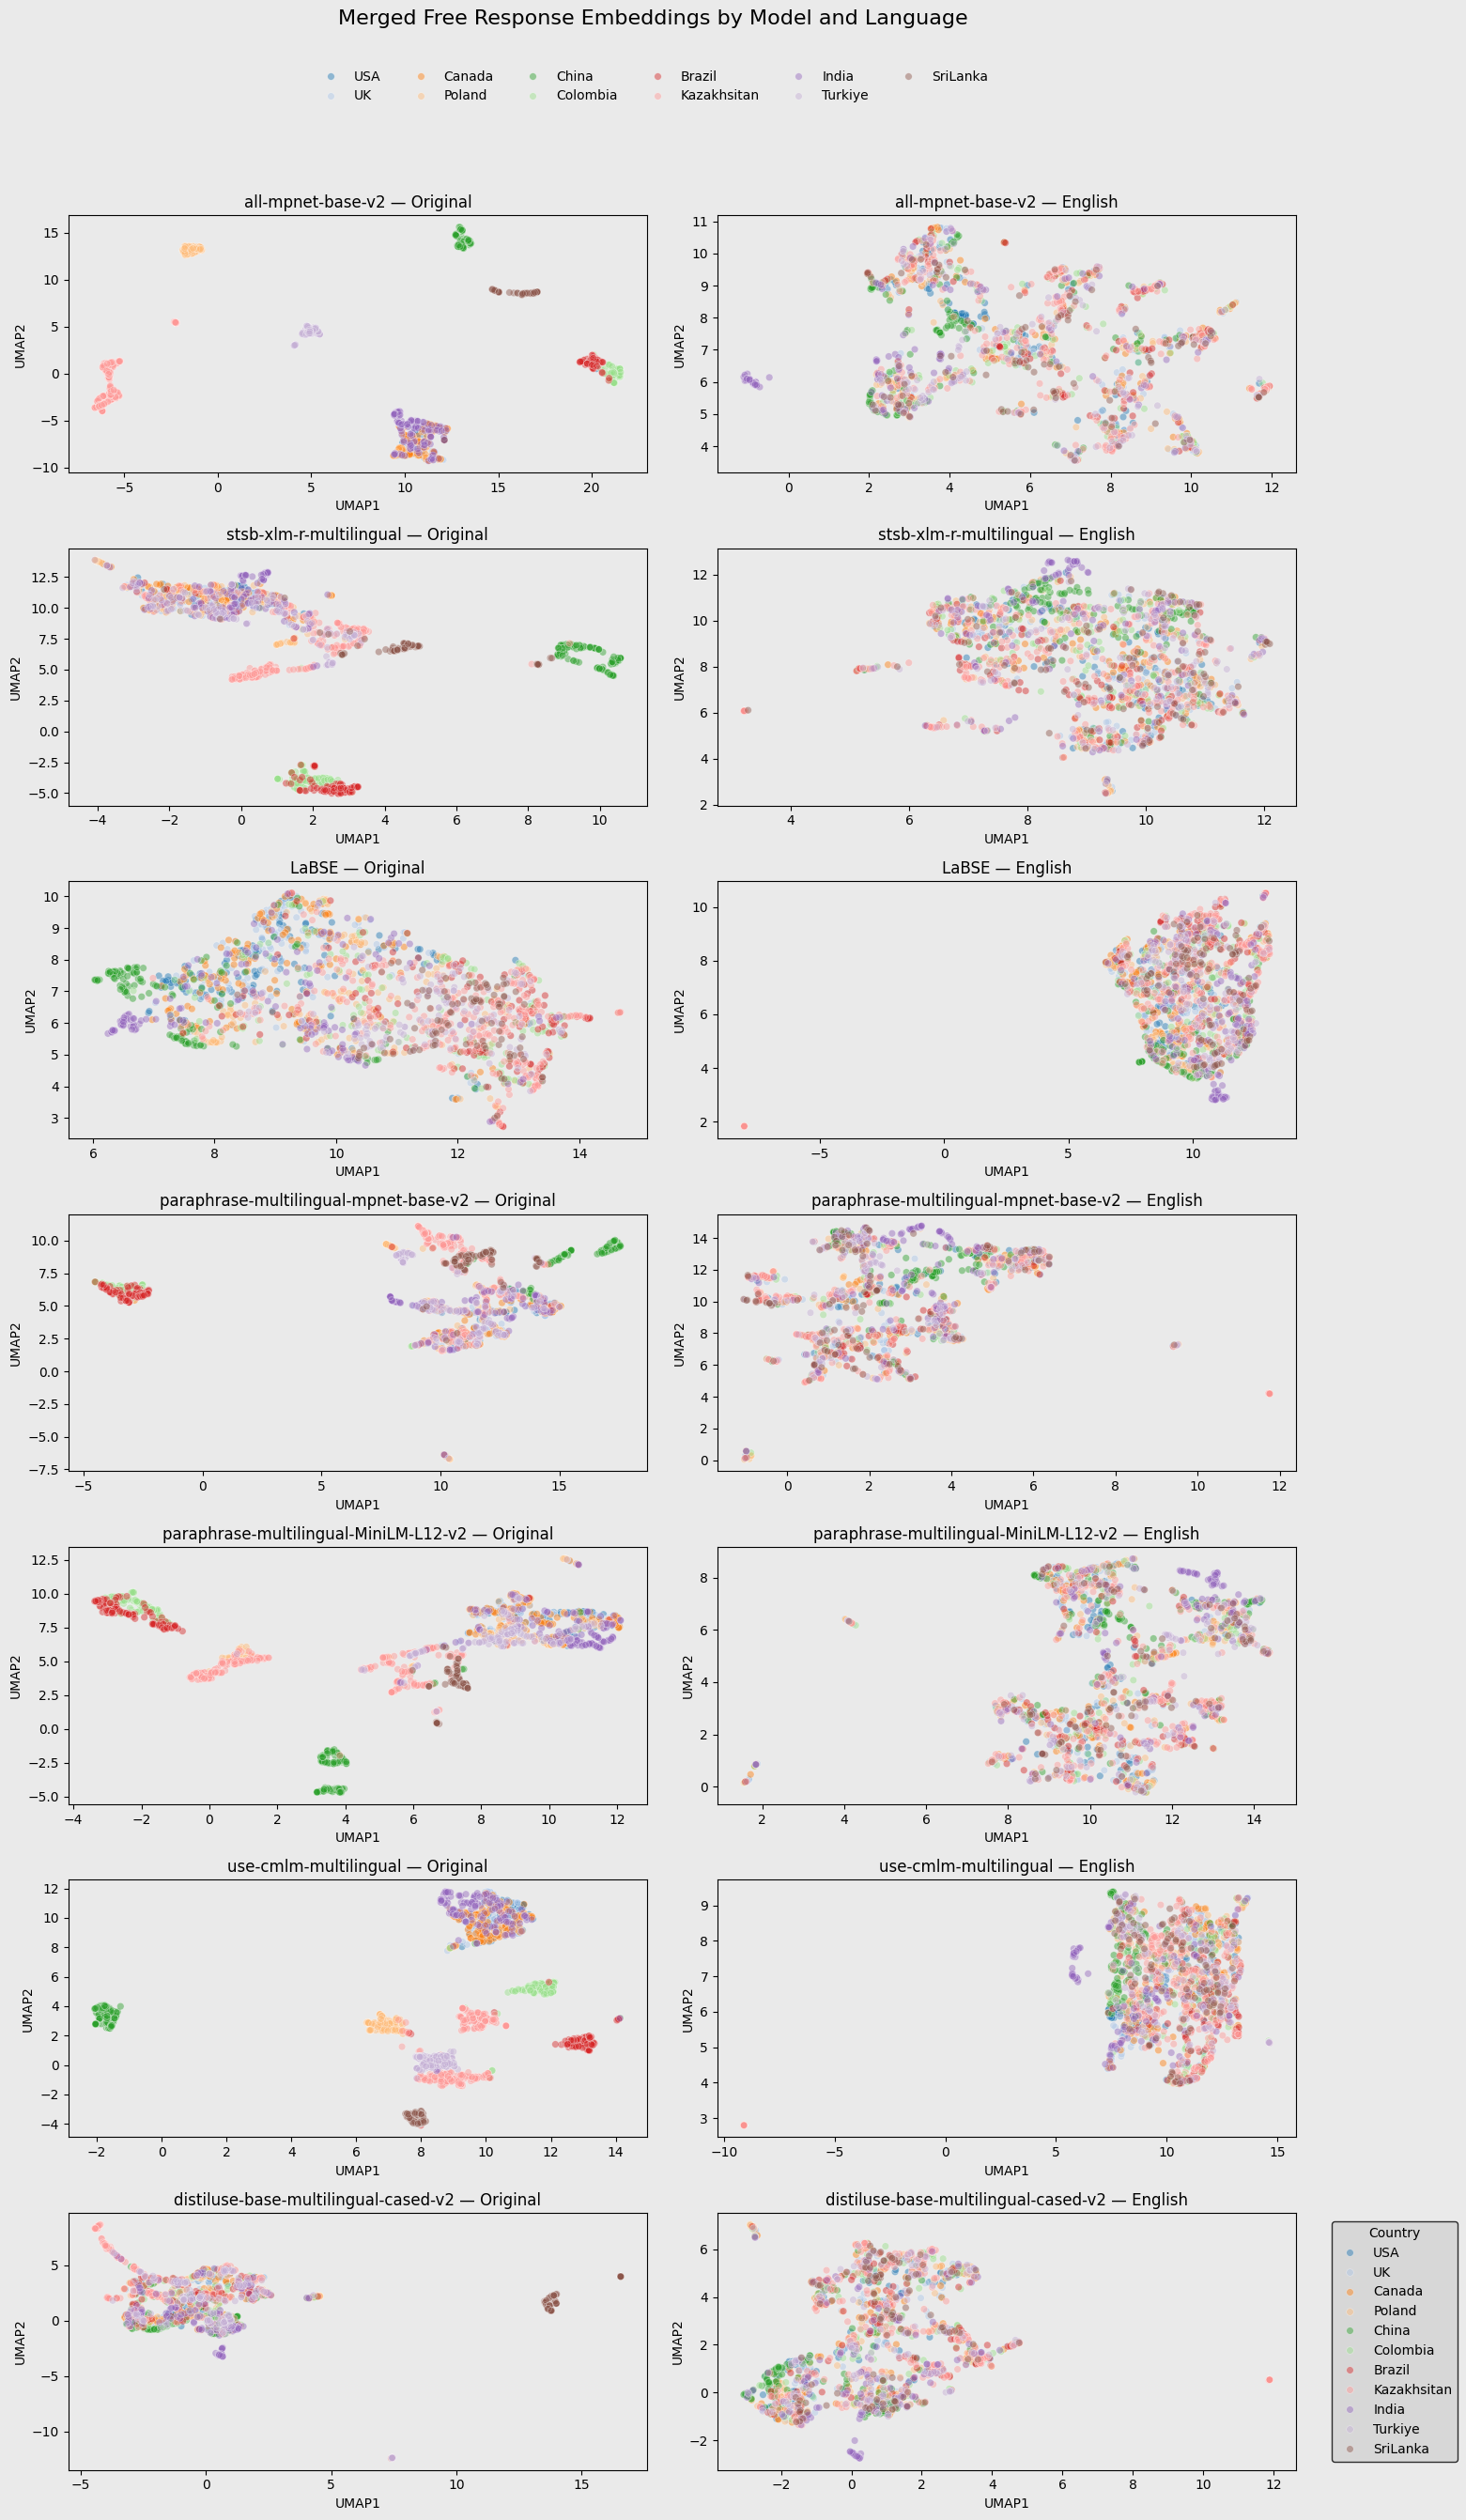

In [ ]:
'''
The purpose of this chunk of code is to compare embeddings from different models and on different versions of the text (original language vs. english)
'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# list of models
model_names = [
    'sentence-transformers/all-mpnet-base-v2',
    'sentence-transformers/stsb-xlm-r-multilingual',
    'sentence-transformers/LaBSE',
    'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
    'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
    'sentence-transformers/use-cmlm-multilingual',
    'sentence-transformers/distiluse-base-multilingual-cased-v2',
]

# Columns in the plot: replace '' with actual English column name
target_columns = ['Open_Q1_2_original', 'Open_Q1_2_en']  # Modify 'English_Q1' appropriately
column_labels = ['Original', 'English']
output_dir = '/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/'

# 2d UMAP reducer
reducer = umap.UMAP( # for eda
    n_components=2,
    n_neighbors=10,
    metric='cosine',
    min_dist=0.01,
    random_state=12345 # You can either use the seed for reproducibility, or use a greater number of CPU cores for the operation, not both.
)

# Predefine color palette based on all unique countries
unique_countries = df['Country'].dropna().unique()
palette = sns.color_palette('tab20', n_colors=len(unique_countries))
country_to_color = dict(zip(unique_countries, palette))

# Prepare plot
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(14, 26))
axes = axes.flatten()

# Set off-white background
background = '#EAEAEA'
fig.patch.set_facecolor(background)
for ax in axes:
    ax.set_facecolor(background)

for i, model_name in enumerate(model_names):
    model_id = model_name.split("/")[-1]
    
    for j, col in enumerate(target_columns):
        emb_path = os.path.join(output_dir, f'emb_{col}_{model_id}.npy')
        if not os.path.exists(emb_path):
            print(f"Missing file: {emb_path}")
            continue
        
        embeddings = np.load(emb_path)
        embed_2d = reducer.fit_transform(embeddings)

        plot_df = pd.DataFrame(embed_2d, columns=['UMAP1', 'UMAP2'])
        plot_df['Country'] = df['Country'].values

        ax = axes[i * 2 + j]
        plot = sns.scatterplot(
            data=plot_df,
            x='UMAP1',
            y='UMAP2',
            hue='Country',
            palette=country_to_color,
            s=30,
            alpha=0.45,
            ax=ax,
            legend=False if i * 2 + j != 0 else 'brief'
        )
        if i * 2 + j == 0:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend_.remove()
        ax.set_title(f'{model_id} — {column_labels[j]}')


# Finalize layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle and legend
fig.suptitle('Merged Free Response Embeddings by Model and Language', fontsize=16, y=1.03)
if handles and labels:
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=6, frameon=False)
    legend = plt.legend(
    handles=handles,
    labels=labels,
    bbox_to_anchor=(1.05, 0.5),
    loc='center left',
    frameon=True,
    facecolor='lightgrey',
    edgecolor='black',
    title='Country'
)

plt.show()

In [ ]:
# This is a temp chunk just for printing the text of the one outlier response in the bottom left of the English LABSE plot
import numpy as np
import pandas as pd

# Assume embed_2d is the UMAP result (n_samples x 2)
# and df is the original DataFrame containing 'Open_Q1_2_en'

# Create DataFrame for easy indexing
umap_df = pd.DataFrame(embed_2d, columns=['UMAP1', 'UMAP2'])

# Find index of the point furthest in the bottom-left (min UMAP1 + UMAP2)
outlier_index = (umap_df['UMAP1'] + umap_df['UMAP2']).idxmin()

# Print the corresponding text
import textwrap

# Wrap and print the outlier text nicely
outlier_text = df.loc[outlier_index, 'Open_Q1_2_en']
wrapped_text = textwrap.fill(outlier_text, width=80)

print("Outlier index:", outlier_index)
print("Outlier UMAP coordinates:", embed_2d[outlier_index])
print("Outlier text (Open_Q1_2_en):")
print(wrapped_text)

Outlier index: 476
Outlier UMAP coordinates: [1.545261   0.14705762]
Outlier text (Open_Q1_2_en):
1. What was this difficult decision about? Please describe in detail who was
involved, where and when it took place, and what was happening at that time.
Well, it's hard to choose the hardest decision. However, the hardest was
probably the one to put our previous dog to sleep. My husband and I shared this
terrible and sad moment. It happened about 6 years ago. Our dog Max was 9 years
old and had been losing weight for some time. Of course, there were visits to
the vet, x-rays, tests, medicines. Unfortunately, it turned out that he had some
kind of stomach cancer and there was probably no way to save him. We had to
decide whether to keep him alive with medicines and watch him suffer, or decide
to put him to sleep. We decided, in consultation with the vet, that this would
be the better decision for our beloved pet... Our hearts were breaking, but we
didn't want him to continue to suffer and 

# Topic Modeling

In [ ]:
# Define the topic modeling pipeline
import tiktoken
import openai
import numpy as np
import torch
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
import umap
import hdbscan

# Set global reproducibility seed
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)

# UMAP dimensionality reduction
# Reference: https://arxiv.org/pdf/1802.03426
# Implementation: https://umap-learn.readthedocs.io/en/latest/parameters.html#metric
umap_model = umap.UMAP(
    n_components=6,     # tunable: (3 levels: 4-7)
    n_neighbors=15,     # tunable: (4 levels: 10-20)
    min_dist=0.1,       # tunable: (4 levels levels: .01, .3)
    metric='cosine',    
    random_state=seed
) 

# HDBSCAN clustering
# Reference: 
# Implementation:

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples = 1, # 1 minimizes outliers
    metric='euclidean',
    cluster_selection_method='leaf',
    approx_min_span_tree=False, # must be off to have reproducibility
    prediction_data=True
)

# Vectorizer and transformation model
vectorizer = CountVectorizer(ngram_range=(2, 4), stop_words="english") # remove stopwords here, but not before the embedding
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Set-up GPT labelling
# Tokenizer
tokenizer= tiktoken.encoding_for_model("gpt-4o")
# Create your representation model
client = openai.OpenAI(api_key="<your_key>")

from bertopic.representation import OpenAI
import openai
prompt = """
You will extract a short topic label from given documents and keywords. 
*ALL* documents are survey responses to questions about a difficult life decision. Therefore, your goal is to determine a representative, specific, and distinctive label for the documents and keywords within the broader context of difficult life decisions.
Here are two examples of topics you created before for a similar dataset that was not about difficult life decisions:

# Example 1
Sample texts from this topic:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the worst food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

Keywords: meat beef eat eating emissions steak food health processed chicken
topic: Environmental impacts of eating meat

# Example 2
Sample texts from this topic:
- I have ordered the product weeks ago but it still has not arrived!
- The website mentions that it only takes a couple of days to deliver but I still have not received mine.
- I got a message stating that I received the monitor but that is not true!
- It took a month longer to deliver than was advised...

Keywords: deliver weeks product shipping long delivery received arrived arrive week
topic: Shipping and delivery issues

# Your task
Sample texts from this topic:
[DOCUMENTS]

Keywords: [KEYWORDS]

Based on the information above, extract a short topic label (three words at most) in the following format:
topic: <topic_label>"""

gpt = OpenAI(
    client,
    model="gpt-4o",
    delay_in_seconds=3,
    chat=True,
    nr_docs=10,
    doc_length=512,
    tokenizer=tokenizer,
    prompt=prompt
)

from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import KeyBERTInspired
mmr = MaximalMarginalRelevance(diversity=.9)
keybertins = KeyBERTInspired(top_n_words=20)

# Use one before GPT
representation_models = {
    # "keybertins":  keybertins,
    "mmr":  mmr,
    "gpt":  gpt,
}


# Define BERTopic model
topic_model = BERTopic(
    vectorizer_model=vectorizer,
    ctfidf_model=ctfidf_model,
    representation_model=representation_models, # representation_models
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    top_n_words=10,
    calculate_probabilities=True,
    verbose=True)
        
        
# Apply topic modeling pipeline
import pandas as pd
import numpy as np

# Prepare the actual text for interpretation
def remove_question_text(text_series, questions):
    # Build list of (compiled pattern, replacement)
    replacements = [
        (re.compile(re.escape(q)), f"Question #{i+1}:") 
        for i, q in enumerate(questions)
    ]
    
    def substitute(text):
        for pattern, label in replacements:
            text = pattern.sub(label, text)
        return text.strip()
    
    return text_series.apply(substitute)


question_text = [ # use regex to cut these out
    "1. What was this difficult decision about? Please describe in detail who was involved, where and when it took place, and what was happening at that time.",
    "2. What specific issues did you encounter when making this difficult decision?",
    #"3. What were you thinking when you first encountered this difficult decision?",
    #"4. What were you feeling when you first encountered this difficult decision?",
    #"5. If you are comfortable sharing, what steps did you take to address this difficult decision?",
    #"6. In what ways did this difficult decision affect your life?",
    #"7. Is there anything else you would like to share about this difficult decision?"
]
docs = df['Open_Q1_2_en'].astype(str) # use _original version to get the actual language
docs = remove_question_text(docs, question_text)

# load corresponding precomputed embeddings
embeddings = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Open_Q1_2_en_all-mpnet-base-v2.npy')

# Fit the BERTopic model to the documents and embeddings
topics, probabilities = topic_model.fit_transform(docs, embeddings) # emb_all_qs_original, emb_Q1_original

# Extract topic-term tf-idf matrix
topic_term_matrix = topic_model.c_tf_idf_

# Construct DataFrame with topic probabilities per document
# pretty sure this doesn't inlucded predicted probabilityes for outlier comments
df_probabilities = pd.DataFrame(probabilities, columns=[f"Topic_{i}" for i in range(probabilities.shape[1])])

# Combine with original comment-level metadata
df = pd.concat([df, df_probabilities], axis=1)

# Optionally save outputs
# df_combined.to_csv("/path/to/output/topic_probabilities.csv", index=False)
# topic_model.save("/path/to/output/bertopic_model", serialization="safetensors", save_ctfidf=True)

# To load a previously saved model
# topic_model = BERTopic.load("/path/to/output/bertopic_model")

2025-06-26 23:23:26,747 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-26 23:23:30,238 - BERTopic - Dimensionality - Completed ✓
2025-06-26 23:23:30,239 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-26 23:23:30,300 - BERTopic - Cluster - Completed ✓
2025-06-26 23:23:30,302 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 25/25 [01:34<00:00,  3.79s/it]
2025-06-26 23:25:05,586 - BERTopic - Representation - Completed ✓


In [168]:
import bertopic

# produce a table where each row is a topic, and each columns records metadata about the topic, like the top phrases, 3 most representative comments, number of comments per topic, etc.
topic_model_summary = topic_model.get_topic_info()

# Function to unnest lists in the Representative_Docs column, placing each comment in its own column
def unnest_comments(row):
    comments = ast.literal_eval(row['Representative_Docs']) if isinstance(row['Representative_Docs'], str) else row['Representative_Docs']
    for i, comment in enumerate(comments):
        row[f'comment_{i+1}'] = comment
    return row

# Apply the function to each row in the dataframe
unnested_topic_model_summary = topic_model_summary.apply(unnest_comments, axis=1)

# Drop the original Representative_Docs column
unnested_topic_model_summary = unnested_topic_model_summary.drop(columns=['Representative_Docs'])

# turn on if using gpot in representation_models
#gpt_list = unnested_topic_model_summary['gpt'].tolist()
#for item in gpt_list:
#    print(item)
    
# Display the result
unnested_topic_model_summary

,Topic,Count,Name,Representation,mmr,gpt,comment_1,comment_2,comment_3
0,-1,404,-1_difficult decision_question difficult_quest...,"[difficult decision, question difficult, quest...","[difficult decision, question difficult, quest...",[Career vs. Family],Question #1: Difficult decision: whether to qu...,Question #1: The most difficult decision: whet...,Question #1: Difficult decision: whether to en...
1,0,105,0_decision divorce_divorce question_question d...,"[decision divorce, divorce question, question ...","[decision divorce, divorce question, question ...",[Divorce and Relationships],Question #1: The most difficult decision I've ...,Question #1: I was cleaning my kitchen and I a...,Question #1: Sometimes the hardest decision is...
2,1,103,1_new job_job question_quit job_leave job,"[new job, job question, quit job, leave job, c...","[new job, job question, quit job, leave job, c...",[Job Transition Challenges],Question #1: It was a decision I made just a f...,Question #1: I work for a flexible working hou...,Question #1: I had just gotten married and had...
3,2,100,2_nursing home_question father_surgery questio...,"[nursing home, question father, surgery questi...","[nursing home, question father, surgery questi...",[Medical Treatment Decisions],Question #1: The most difficult decision for m...,Question #1: Deciding whether or not to visit ...,"Question #1: 1. Scene review: Winter of 2018, ..."
4,3,99,3_relationship question_longterm relationship_...,"[relationship question, longterm relationship,...","[relationship question, longterm relationship,...",[Ending Toxic Relationships],Question #1: The one dificult decision that i ...,Question #1: Breaking up with my ex. He made m...,Question #1: This decision concerned the end o...
5,4,83,4_real estate_house question_buy house_new house,"[real estate, house question, buy house, new h...","[real estate, house question, buy house, new h...",[Housing and Relocation],Question #1: The decision to buy a flat and th...,Question #1: I bought a property as an investm...,"Question #1: Two years ago, I faced an extreme..."
6,5,73,5_job question_senior management_development t...,"[job question, senior management, development ...","[job question, senior management, development ...",[Workplace Decision-Making],"Question #1: In March, the colleague in charge...","Question #1: During the peak corona period, as...",Question #1: This difficult decision was about...
7,6,69,6_question na question_na question_question na...,"[question na question, na question, question n...","[question na question, na question, question n...",[Ethical and Moral Dilemmas],Question #1: A difficult decision that I faced...,Question #1: TEST A difficult decision that I ...,Question #1: It was a situation that occurred ...
8,7,59,7_start business_starting business_job start_j...,"[start business, starting business, job start,...","[start business, starting business, job start,...",[Career vs. Entrepreneurship],Question #1: This difficult decision was about...,Question #1: This difficult decision is about ...,Question #1: The most difficult decision I hav...
9,8,59,8_primary school_new school_private school_sch...,"[primary school, new school, private school, s...","[primary school, new school, private school, s...",[Child Education Decisions],Question #1: I do an aftercare school program ...,Question #1: About choosing a school for the c...,Question #1: The difficult decision I made was...


In [173]:
embed_2d = umap.UMAP(
    n_components=2,
    n_neighbors=10,
    metric='cosine',
    min_dist=0.1,
    random_state=12345).fit_transform(embeddings)

topic_model.visualize_documents(docs, reduced_embeddings=embed_2d,
                                hide_annotations=True, custom_labels=True,
                                width=1800, height=900)

In [174]:
# Bar Chart
import umap

topic_model.visualize_barchart(
    custom_labels=False, # ignored if none provided
    autoscale=True,
    top_n_topics=100, # arbitrarily high number to make sure all are plotted
    n_words=10,
    width=450,
    title="Top 10 phrases per topic"
    )

In [175]:
topic_model.visualize_topics()

In [176]:
topic_model.visualize_heatmap()